**REPLICATION CODE: MOURIFIÉ/HENRY/MEANGO**

Start date: 10/11/2025
Author: Jordi Torres Vallverdú

Goal: idea is to replicate the analysis done by Mourifié et al (2020) in another context with another data. The idea is to seek new applications of their methodology.

Notes on the context: I am using data on Belgium region of Flandes in the 1990s. I have a panel of students observed from the beginning of high-school up to two years into higher education. Given that I don't observe future labor outcomes, I will only consider potential outcomes in terms of success probability of having completed the first year of higher education (this is a proxy for completion)


$D=\{1,0\}$, where 1 is entered stem high school track and 0 if entered non-stem high-school track

$Y=\{1,0\}$, where 1 is graduated from stem degree and 0 is graduated from non-stem degree

Z, set of instruments


In [1]:
using StatFiles, DataFrames

data_path = "/Users/jorditorresvallverdu/Library/Mobile Documents/com~apple~CloudDocs/tse/year1/papers_final_memoire/data/clean/roymodel_database.dta"

export_dir = "/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/"


main = DataFrame(load(data_path))

Row,ID,hs_course1,hs_stem1,postsec_type2,postsec_stem2,c_par_beliefpar_HS_E,c_par_beliefpar_postHS,c_par_childage_homechange,c_par_notsureifB,c_par_yearsinkindergarten,c_par_repeatelementaryeduc,c_par_specialeducelem,c_par_income,c_par_home,c_par_spokenlanguage_dutch_fa,c_par_dialect_fa,c_par_spokenlanguage_dutch_mo,c_par_dialect_mo,c_par_parentschoose,c_par_childchoose,c_par_schoolchoose,c_par_otherchoose,c_par_nochoose,c_bao_advies_school_p0,c_bao_advies_progr_p0,c_bao_advies_welkprogr_p0,c_bao_belief_lkr_endpoint_p0,c_bao_special_p0,c_bao_result_dutch_p0,c_bao_result_math_p0,c_bao_result_all_p0,c_iq_male,c_iq_birth_year,c_iq_birth_month,c_iq_WB1,c_iq_NB1,c_iq_NIQ,c_iq_VIQ,c_iq_SIQ,c_iq_IQ,c_iq_opl,c_sskills_CON1,c_sskills_CON2,c_sskills_AGREE1,c_sskills_AGREE2,c_sskills_EXTRA1,c_sskills_CON3,c_sskills_AGREE3,c_sskills_EXTRA2,c_sskills_EXTRA3,c_sskills_workparents,c_sskills_income,c_sskills_IQ_discrete,z_numeric_iq,income_reduced
,Int32?,Float32?,Float32?,Float32?,Float32?,Int32?,Int32?,Int8?,Int8?,Int8?,Int8?,Int8?,Int32?,Int32?,Float32?,Float32?,Float32?,Float32?,Float32?,Float32?,Float32?,Float32?,Float32?,Int8?,Int8?,Int32?,Int32?,Float32?,Int32?,Int32?,Int32?,Int8?,Int16?,Int8?,Float32?,Float32?,Float32?,Float32?,Float32?,Float32?,Int8?,Int8?,Int8?,Int8?,Int8?,Int8?,Int8?,Int8?,Int8?,Int8?,Float32?,Float32?,Float32?,Int8?,Float32?
1,11135,6.0,1.0,2.0,0.0,6,4,missing,0,3,0,0,4,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,1,7,0.0,5,4,4,1,1978,8,-0.418461,0.609975,91.4869,120.331,109.205,110.171,2,5,5,4,3,4,5,2,4,3,1.0,3.0,5.0,1,2.0
2,11137,6.0,0.0,1.0,0.0,6,4,missing,0,3,0,0,5,1,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,1,1,0.0,5,4,5,0,1978,10,-0.332319,0.560348,97.4658,107.186,100.036,102.72,1,5,5,5,5,5,5,5,5,5,1.0,4.0,4.0,2,3.0
3,11154,6.0,1.0,2.0,0.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,1,1,7,0.0,5,5,5,1,1978,5,0.57565,1.49024,106.991,115.378,104.474,111.563,2,5,5,5,5,5,5,5,5,5,missing,1.0,5.0,3,1.0
4,11161,6.0,1.0,1.0,0.0,6,4,missing,0,4,0,0,5,1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,1,7,0.0,5,5,missing,0,1978,2,0.221887,1.49837,110.288,115.582,99.4507,111.189,3,5,5,5,5,5,5,5,5,5,1.0,4.0,5.0,4,3.0
5,11162,6.0,1.0,1.0,0.0,6,5,missing,0,3,0,0,4,1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,1,7,0.0,5,5,5,0,1978,2,0.988978,0.905644,118.363,100.334,90.7207,103.559,1,5,5,5,5,5,5,5,5,4,1.0,3.0,4.0,6,2.0
6,11163,6.0,1.0,2.0,0.0,6,4,missing,0,3,0,0,5,1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,1,7,0.0,6,6,missing,0,1978,6,0.959115,0.984085,120.458,118.775,126.786,125.161,3,5,5,5,5,5,5,5,5,2,1.0,4.0,6.0,6,3.0
7,11166,6.0,1.0,2.0,0.0,6,missing,missing,0,3,0,0,missing,1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,1,7,0.0,5,6,missing,0,1978,11,0.158003,1.39593,95.3408,91.9245,89.5506,90.9654,3,5,5,5,5,5,5,5,5,5,missing,1.0,3.0,1,1.0
8,11171,6.0,0.0,1.0,0.0,6,3,missing,0,3,0,0,4,1,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,1,7,0.0,6,6,missing,0,1978,5,0.83656,1.99263,110.01,125.206,121.763,123.113,2,5,5,5,5,5,5,5,5,5,1.0,3.0,6.0,4,2.0
9,11172,6.0,1.0,2.0,1.0,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,1,1,7,0.0,5,5,5,1,1978,10,1.0285,0.811891,108.808,96.97,99.3044,101.327,3,5,5,5,5,5,5,5,5,4,missing,1.0,4.0,4,1.0


**1. Data manipulation**

First we create a subsample of observations on gender and socio-economic status, just like they do in their exercise. I will create bins based on this: 

- Gender
- Income categories: 5 brackets
- Minority status (proxied by family background)


In [2]:
using DataFramesMeta, Statistics 

groups = groupby(main, [:c_sskills_income, :c_iq_male])
subsamples = [DataFrame(g) for g in groups]



10-element Vector{DataFrame}:
 305×55 DataFrame
 Row │ ID      hs_course1  hs_stem1  postsec_type2  postsec_stem2  c_par_belie ⋯
     │ Int32?  Float32?    Float32?  Float32?       Float32?       Int32?      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  11166         6.0       1.0            2.0            0.0              ⋯
   2 │  11246         6.0       0.0            1.0            0.0
   3 │  11272         6.0       1.0            2.0            0.0
   4 │  11311         6.0       1.0            2.0            0.0
   5 │  11457         6.0       0.0            2.0            0.0              ⋯
   6 │  11473         6.0       0.0            2.0            0.0
   7 │  12652         6.0       0.0            2.0            0.0
   8 │  12666         4.0       0.0            2.0            0.0             
  ⋮  │   ⋮         ⋮          ⋮            ⋮              ⋮                 ⋮  ⋱
 299 │  42322         4.0       0.0            2.0       

**Using IQ as instrument**-->classic Manski Pepper type of instrument






**2. Estimating bounds on the L(z) measure**

The goal is now to understand what explains the violations of Roy selection model using the same method as in Mourifié, Henry, Meango (2020). Will keep the same example going, but, if needed, I will also include a continuous instrument: example can be numeric IQ estimated at baseline. 

The main issue with this literature is that sample analogs of $\Theta_I$ are the suprema and infima of estimated bounding functions and they have substantial finite sample bias and estimated bounds tend to be much tighter than population bounds. -->Manski/Pepper (2001).

I think I need to treat the instrument as continuous; if not it is meaningless. Because CRL seems to be devised with this property. Then I probably need to adapt the test for monothonicity too. But so far, I have something, which is fine.

Start simple; support is discrete; then we do the same exercise with a continuous instrument. 

**Extension to account for Z being continuous**--> this should go more in line with Chernozhukov Lee Rosen. 

In [3]:
##Case where Z is discrete. This is following their comments p.708-709, final note. I will use Z==education bins


In [4]:
using DataFrames, Statistics

function cell_probs_0(df::DataFrame, instrument::Symbol, yvar::Symbol)

    zvals = sort(unique(df[!, instrument]))
    k = length(zvals)
    n = nrow(df)

    beta_hat = Vector{Float64}(undef, k)   
    n_k      = Vector{Int}(undef, k)      

    for (j, z) in enumerate(zvals) #j is position and z is value in a vector
        idx = df[!, instrument] .== z
        nj = count(idx)
        n_k[j] = nj

        if nj == 0
            beta_hat[j] = NaN
        else
            beta_hat[j] = mean(df[idx, yvar] .== 0)
        end
    end

    return zvals, beta_hat, n_k, n, k
end


cell_probs_0 (generic function with 1 method)

In [5]:
zvals, beta_hat, n_k, n, k = cell_probs_0(subsamples[1], :c_iq_opl, :postsec_stem2)


(Union{Missing, Int8}[1, 2, 3], [0.75, 0.6355140186915887, 0.5666666666666667], [108, 107, 90], 305, 3)

In [6]:
#3.Estimate asymptotic variance

using LinearAlgebra

function variance_compute(beta_hat::Vector{Float64}, n_k::Vector{Int}, n::Int)
    k = length(beta_hat)
    Ωdiag = zeros(Float64, k)

    for j in 1:k
         if n_k[j] == 0 || isnan(beta_hat[j])
            Ωdiag[j] = NaN

         else 
        Ωdiag[j] = n * beta_hat[j] * (1.0 - beta_hat[j]) / n_k[j]
         end 
    end
    Ω = Diagonal(Ωdiag)
    sqrt_Ω= Diagonal(sqrt.(Ωdiag))
    return Ω, sqrt_Ω
end


variance_compute (generic function with 1 method)

In [7]:
Ω, Ω_sqrt=variance_compute(beta_hat, n_k, n)

([0.5295138888888888 0.0 0.0; 0.0 0.6602707007019346 0.0; 0.0 0.0 0.8321604938271605], [0.7276770498572075 0.0 0.0; 0.0 0.8125704281488064 0.0; 0.0 0.0 0.912228312335876])

In [8]:
function define_moments_for_j(beta_hat::Vector{Float64}, j::Int)
    k = length(beta_hat)

    V = collect(1:j-1)         
    M = length(V)

    p_list = Vector{Vector{Float64}}(undef, M)
    theta_hat = Vector{Float64}(undef, M)

    for (m, i) in enumerate(V)
        p = zeros(Float64, k)
        p[j] =  1.0
        p[i] = -1.0
        p_list[m] = p

        theta_hat[m] = beta_hat[j] - beta_hat[i]
    end

    return V, p_list, theta_hat
end


define_moments_for_j (generic function with 1 method)

In [9]:
#step 5

using LinearAlgebra

function compute_g_and_s(p_list::Vector{Vector{Float64}}, Ω_sqrt::Diagonal, n::Int)
    M= length(p_list)
    k=length(p_list[1])

    g_hats = Vector{Vector{Float64}}(undef, M)
    s_n    = Vector{Float64}(undef, M)

    for m in 1:M
        g_hats[m]= vec(p_list[m]'*Ω_sqrt)
        s_n[m] = norm(g_hats[m]) / sqrt(n)
    end 

    return g_hats, s_n
end



compute_g_and_s (generic function with 1 method)

In [10]:
#step 6

using LinearAlgebra, Statistics

function clr_critical_value(g_hats::Vector{Vector{Float64}}, R::Int, n::Int, critic::Float64; rng=Random.default_rng())

    M = length(g_hats)           
    K = length(g_hats[1])        

    T = zeros(Float64, R)

    for r in 1:R
        Zr = randn(rng, K)

        best = -Inf
        vals = zeros(M)
        for m in 1:M
            g = g_hats[m]
            val = dot(g, Zr) / norm(g)

            if val>best 
                best=val
            end    
        end

        T[r] = best
    end

    k_nV = quantile(T, critic)

    return k_nV
end


clr_critical_value (generic function with 1 method)

In [11]:
function restrict_moments(theta_hat::Vector{Float64}, k_nV::Float64, s_n::Vector{Float64})

    M = length(theta_hat)
    B = similar(theta_hat)

    for m in 1:M
        B[m] = theta_hat[m] + k_nV * s_n[m]
    end
    
    b = minimum(B)

    V_hat_idx = Int[]

    for m in 1:M
        if theta_hat[m] <= b + 2 * k_nV * s_n[m]
            push!(V_hat_idx, m)
        end
    end

    return V_hat_idx
end


restrict_moments (generic function with 1 method)

In [12]:
function clr_lower_bound(theta_hat, s_n, k_nVhat)
    minimum(theta_hat .+ k_nVhat .* s_n)
end


clr_lower_bound (generic function with 1 method)

In [13]:
function clr_lower_bound_for_j(theta_hat, s_n, k_nVhat, Vhat)

    return minimum(theta_hat[m] .+ k_nVhat .* s_n[m] for m in Vhat)

end 

clr_lower_bound_for_j (generic function with 1 method)

In [14]:
function clr_el_discrete(df::DataFrame, Z::Symbol, Y::Symbol; R=2000, rng=Random.default_rng())
    zvals, beta_hat, n_k, n, k = cell_probs_0(df, Z, Y)
    _, Ωsqrt = variance_compute(beta_hat, n_k, n)

    el_L = fill(NaN, k)
    el_L[1] = 0.0 #by default, first point in discrete case will be 00

    for j in 2:k
        V, p_list, theta_hat = define_moments_for_j(beta_hat, j)
        g_hats, s_n = compute_g_and_s(p_list, Ωsqrt, n)

        γ_n = 1 - 0.1 / log(n)


        k_nV = clr_critical_value(g_hats, R, n,γ_n; rng )
        Vhat = restrict_moments(theta_hat, k_nV, s_n)

        g_hats_Vhat = g_hats[Vhat]

        k_nV_2 = clr_critical_value(g_hats_Vhat, R, n, 0.90; rng)


        el_L[j] = minimum(theta_hat[m] + k_nV_2*s_n[m] for m in Vhat)
    end

    return zvals, beta_hat, el_L
end


clr_el_discrete (generic function with 1 method)

In [15]:

using Random
Random.seed!(12345)

N= length(subsamples)

results= [clr_el_discrete(i, :c_iq_opl, :postsec_stem2; R=2000, rng=Random.default_rng()) for i in subsamples]


10-element Vector{Tuple{Vector{Union{Missing, Int8}}, Vector{Float64}, Vector{Float64}}}:
 ([1, 2, 3], [0.75, 0.6355140186915887, 0.5666666666666667], [0.0, -0.03203262125346211, -0.08499678197344186])
 ([1, 2, 3], [0.4444444444444444, 0.3924050632911392, 0.45794392523364486], [0.0, 0.0455188370183552, 0.13279491905540375])
 ([1, 2, 3], [0.7560975609756098, 0.7246376811594203, 0.6052631578947368], [0.0, 0.05525615657279066, -0.02594447085862138])
 ([1, 2, 3], [0.40625, 0.4473684210526316, 0.3157894736842105], [0.0, 0.17764873444646923, 0.07464053641906937])
 ([1, 2, 3], [0.7297297297297297, 0.626984126984127, 0.6904761904761905], [0.0, -0.014351935822317599, 0.07423386773528895])
 ([1, 2, 3], [0.42105263157894735, 0.4507042253521127, 0.35185185185185186], [0.0, 0.14627601822329178, 0.03727301787649906])
 ([1, 2, 3], [0.7777777777777778, 0.6515151515151515, 0.7074829931972789], [0.0, 0.025244497595242, 0.10409420284820939])
 ([1, 2, 3], [0.42857142857142855, 0.45652173913043476, 0.42056

In [16]:
zgrid = results[1][1]   # [1,2,3]
G = length(zgrid)
B = length(results) ÷ 2

el_women = zeros(G, B)
el_men   = zeros(G, B)

for b in 1:B
    el_women[:, b] .= max.(results[2*b - 1][3], 0.0)
    el_men[:, b]   .= max.(results[2*b][3], 0.0)
end


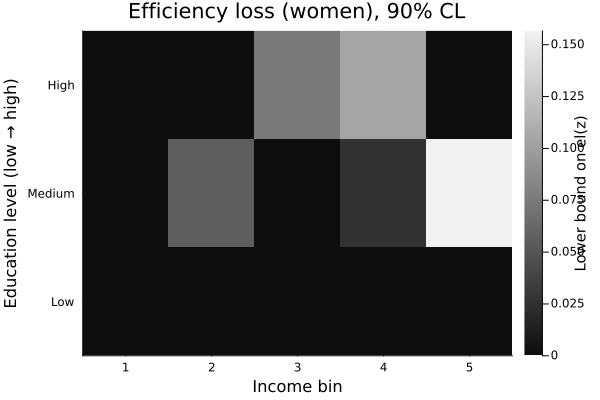

In [17]:
using Plots

pdiscrete=heatmap(
    1:B,
    1:G,
    el_women;
    xlabel = "Income bin",
    ylabel = "Education level (low → high)",
    yticks = (1:G, ["Low", "Medium", "High"]),
    title  = "Efficiency loss (women), 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_women)),
    colorbar_title = "Lower bound on el(z)"
)


In [18]:
savefig(pdiscrete, joinpath(export_dir, "efficiency_loss_women_discrete.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_women_discrete.png"

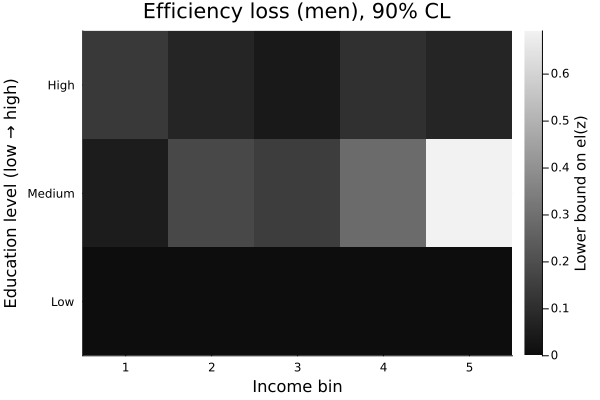

In [19]:
using Plots

pdiscrete=heatmap(
    1:B,
    1:G,
    el_men;
    xlabel = "Income bin",
    ylabel = "Education level (low → high)",
    yticks = (1:G, ["Low", "Medium", "High"]),
    title  = "Efficiency loss (men), 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_men)),
    colorbar_title = "Lower bound on el(z)"
)

In [20]:
savefig(pdiscrete, joinpath(export_dir, "efficiency_loss_men_discrete.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_men_discrete.png"

**CASE WHERE Z IS CONTINUOUS**

In [21]:
using StatsBase, CategoricalArrays

#Functions used throughout

function rescale_to_unit(z::Vector{Float64})
    zmin, zmax = minimum(z), maximum(z)
    ztilde = (z .- zmin) ./ (zmax - zmin)  
    return ztilde, zmin, zmax
end

function poly_basis(z::Vector{Float64}, K::Int)
    n = length(z)
    P = Matrix{Float64}(undef, n, K)
    for k in 1:K
        P[:, k] .= z .^ (k - 1)
    end
    return P
end





poly_basis (generic function with 1 method)

In [22]:
###Same, but let's allow for Z to be continuous. This is a full replication of CLR algorithm in page 708-709 of Chernozhukov, Lee, Rosen ECTA 2013 paper.

using DataFrames, Statistics, LinearAlgebra

function cell_probs_0_continuous(df::DataFrame, instrument::Symbol, yvar::Symbol, Order::Int, G::Int)

    z_raw= Float64.(df[!,instrument]) #returns vector nx1
    

    z_rescale, zmin, zmax= rescale_to_unit(z_raw) #rescales vector to lie between 0-1->numerical reasons
    P= poly_basis(z_rescale,Order) #computes nxk basis


    Y_0= Float64.(df[!,yvar].==0) #returns vector nx1
    n=length(Y_0)


    beta_hat= (P'*P)\(P'*Y_0) #k*1 betas

    #project discretized bins

    zgrid_unit = range(0.0, 1.0; length = G)
    zgrid = zmin .+ zgrid_unit .* (zmax - zmin)     

    Pgrid = poly_basis(collect(zgrid_unit), Order)      #G×K

    theta_hat_grid = Pgrid * beta_hat                   #G*1

    G= length(zgrid)



    return theta_hat_grid, Pgrid, zgrid, Y_0, beta_hat, P, G, n
end

cell_probs_0_continuous (generic function with 1 method)

In [23]:
theta_hat_grid, Pgrid, zgrid, Y_0, beta_hat, P, G, n =cell_probs_0_continuous(subsamples[1], :c_iq_NIQ, :postsec_stem2, 4, 100)

([1.0152171045513982, 0.993226600400362, 0.9722108036684572, 0.952147972828578, 0.9330163663536184, 0.9147942427164726, 0.8974598603900344, 0.8809914778471982, 0.8653673535608578, 0.8505657460039076  …  0.38558034017493836, 0.364238687686481, 0.34191500517762086, 0.3185875511212519, 0.2942345839902698, 0.268834362257567, 0.24236514439603812, 0.2148051888785774, 0.1861327541780785, 0.15632609876743553], [1.0 0.0 0.0 0.0; 1.0 0.010101010101010102 0.0001020304050607081 1.0306101521283648e-6; … ; 1.0 0.98989898989899 0.9799000102030406 0.9700020303019998; 1.0 1.0 1.0 1.0], 74.16575622558594:0.6005239775686553:133.6176300048828, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0], [1.0152171045513982, -2.2260253985940976, 4.883098061036551, -3.515963668226416], [1.0 0.3561719022297919 0.12685842393798843 0.04518340616786671; 1.0 0.6780860152793541 0.45980064411743243 0.31178438659247015; … ; 1.0 0.7838300689023617 0.6143895769154811 0.4815

In [24]:
using LinearAlgebra

function variance_compute_cont(Y_0, P, n, beta_hat)

    u_i=similar(Y_0)
    u_i= Y_0 - (P*beta_hat) #n*1

    Q= (P'*P)./n # k*k
    S= (1/n).*P'*Diagonal(u_i.^2)*P # k*n *n*n * n*k -> k*k

    Ω= inv(Q)*S*inv(Q) #->k*k

    Ω = (Ω + Ω') / 2

    eig = eigen(Symmetric(Ω))
    λ = eig.values
    V = eig.vectors

    λ_pos = max.(λ, 0.0)              # truncate negatives
    sqrtΩ = V * Diagonal(sqrt.(λ_pos))


    return Ω , sqrtΩ



end 

variance_compute_cont (generic function with 1 method)

In [25]:
Ω , sqrtΩ= variance_compute_cont(Y_0, P, n, beta_hat)

P

theta_hat_grid

100-element Vector{Float64}:
 1.0152171045513982
 0.993226600400362
 0.9722108036684572
 0.952147972828578
 0.9330163663536184
 0.9147942427164726
 0.8974598603900344
 0.8809914778471982
 0.8653673535608578
 0.8505657460039076
 ⋮
 0.364238687686481
 0.34191500517762086
 0.3185875511212519
 0.2942345839902698
 0.268834362257567
 0.24236514439603812
 0.2148051888785774
 0.1861327541780785
 0.15632609876743553

In [26]:

function define_moments_for_j_cont(theta_hat_grid::Vector{Float64}, j::Int, Pgrid::Matrix{Float64})

    V = collect(1:j-1)         
    M = length(V)

    p_list = Vector{Vector{Float64}}(undef, M)
    theta_hat = Vector{Float64}(undef, M)

    for (m, i) in enumerate(V)
        p_list[m] = Pgrid[j, :] - Pgrid[i, :]
        theta_hat[m] = theta_hat_grid[j] - theta_hat_grid[i]
    end

    return V, p_list, theta_hat
end

define_moments_for_j_cont (generic function with 1 method)

In [27]:
V, p_list, theta_hat =
    define_moments_for_j_cont(theta_hat_grid, 2, Pgrid)


([1], [[0.0, 0.010101010101010102, 0.0001020304050607081, 1.0306101521283648e-6]], [-0.021990504151036205])

In [28]:
using LinearAlgebra

function compute_g_and_s_cont(p_list::Vector{Vector{Float64}}, Ω_sqrt::AbstractMatrix, n::Int)
    M= length(p_list)

    g_hats = Vector{Vector{Float64}}(undef, M)
    s_n    = Vector{Float64}(undef, M)

    for m in 1:M
        g_hats[m]= vec(p_list[m]'*Ω_sqrt)
        s_n[m] = norm(g_hats[m]) / sqrt(n)
    end 

    return g_hats, s_n
end


compute_g_and_s_cont (generic function with 1 method)

In [29]:
g_hats, s_n=compute_g_and_s_cont(p_list,sqrtΩ,n)

([[0.0017585589188120522, -0.005547955219105077, -0.05039807722872233, 0.17483689439569366]], [0.010424085943631738])

In [30]:
using LinearAlgebra, Statistics

function clr_critical_value_cont(g_hats::Vector{Vector{Float64}}, R::Int, n::Int, critical::Float64; rng=Random.default_rng())

    M = length(g_hats)           
    K = length(g_hats[1])        

    T = zeros(Float64, R)

    for r in 1:R
        Zr = randn(rng, K)

        best = -Inf
        vals = zeros(M)
        for m in 1:M
            g = g_hats[m]
            val = dot(g, Zr) / norm(g)

            if val>best 
                best=val
            end    
        end

        T[r] = best
    end

    k_nV = quantile(T, critical)

    return k_nV
end

clr_critical_value_cont (generic function with 1 method)

In [31]:
k_nV=clr_critical_value_cont(g_hats, 1000, n, 0.95, rng=Random.default_rng())

1.728695864958132

In [32]:
function restrict_moments_cont(theta_hat::Vector{Float64}, k_nV::Float64, s_n::Vector{Float64})

    M = length(theta_hat)
    B = similar(theta_hat)

    for m in 1:M
        B[m] = theta_hat[m] + k_nV * s_n[m]
    end
    
    b = minimum(B)

    V_hat_idx = Int[]

    for m in 1:M
        if theta_hat[m] <= b + 2 * k_nV * s_n[m]
            push!(V_hat_idx, m)
        end
    end

    return V_hat_idx
end


restrict_moments_cont (generic function with 1 method)

In [33]:
V_hat_idx=restrict_moments_cont(theta_hat,k_nV, s_n)

1-element Vector{Int64}:
 1

In [34]:
function clr_lower_bound_for_j_cont(theta_hat, s_n, k_nVhat, Vhat)

    return minimum(theta_hat[m] .+ k_nVhat .* s_n[m] for m in Vhat)

end 

clr_lower_bound_for_j_cont (generic function with 1 method)

In [35]:
function clr_el_cont(df::DataFrame, Z::Symbol, Y::Symbol, order_pol::Int, grid_points::Int; R=2000, rng=Random.default_rng())

    theta_hat_grid, Pgrid, zgrid, Y_0, beta_hat, P, G, n=cell_probs_0_continuous(df, Z, Y, order_pol, grid_points)

    _ , sqrtΩ= variance_compute_cont(Y_0, P, n, beta_hat)

    el_L = fill(NaN, G)
    el_L[1] = 0.0 #by default, first point in discrete case will be 00

    for j in 2:G
        V, p_list, theta_hat = define_moments_for_j_cont(theta_hat_grid, j, Pgrid)        
        g_hats, s_n= compute_g_and_s_cont(p_list, sqrtΩ,n)

        γ_n = 1 - 0.1 / log(n)

        k_nV = clr_critical_value_cont(g_hats, R, n, γ_n; rng)

        Vhat=restrict_moments_cont(theta_hat,k_nV, s_n)

        g_hats_Vhat = g_hats[Vhat]

        k_nV_2 = clr_critical_value_cont(g_hats_Vhat, R, n, 0.90;rng)

        el_L[j] = minimum(theta_hat[m] + k_nV_2*s_n[m] for m in Vhat)
    end

    return zgrid, beta_hat, el_L
end

clr_el_cont (generic function with 1 method)

In [36]:
using Random
Random.seed!(12345)

results= [clr_el_cont(i,:c_iq_NIQ, :postsec_stem2, 4, 100; R=2000, rng=Random.default_rng()) for i in subsamples]

10-element Vector{Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Vector{Float64}, Vector{Float64}}}:
 (74.16575622558594:0.6005239775686553:133.6176300048828, [1.0152171045513982, -2.2260253985940976, 4.883098061036551, -3.515963668226416], [0.0, -0.00844672588364425, -0.017651762083838726, -0.024964385007555212, -0.0319005220644721, -0.03769858891465777, -0.045061192036246575, -0.051532619138218605, -0.05400740794175429, -0.06306995723094114  …  -0.3537238669727716, -0.3483771829295962, -0.37210554997262624, -0.3978390944680333, -0.4069585648515677, -0.42259383187820077, -0.4396559572553109, -0.45468532238168463, -0.49984717445375865, -0.5092424798547142])
 (74.4735336303711:0.6306407427546954:136.90696716308594, [0.405869049641243, 1.1676394301590314, -3.0246754056861804, 1.8959042154004258], [0.0, 0.031284843440690796, 0.03129037756359457, 0.028468462381518112, 0.02718572796686059, 0.02642029986991872, 0.02502204758421504, 0.024094192

In [37]:
##Graph

using Statistics
zgrid = results[1][1]              #common z grid
G = length(zgrid)
B = length(results) ÷ 2            #number of income bins


el_women = zeros(G, B)
el_men   = zeros(G, B)

for b in 1:B
    el_women[:, b] .= max.(results[2*b - 1][3], 0.0) #here I drop negative el. should I do this?

    el_men[:, b]   .= max.(results[2*b][3], 0.0)
end


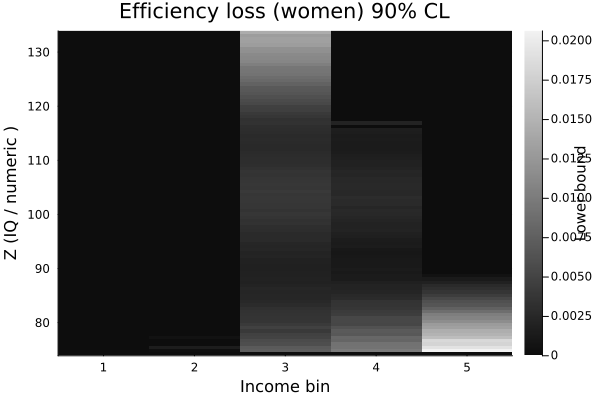

In [38]:
using Plots

p=heatmap(
    1:B, zgrid, el_women;
    xlabel = "Income bin",
    ylabel = "Z (IQ / numeric )",
    title  = "Efficiency loss (women) 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_women)),
    colorbar_title = "Lower bound"
)


In [39]:
savefig(p, joinpath(export_dir, "efficiency_loss_women.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_women.png"

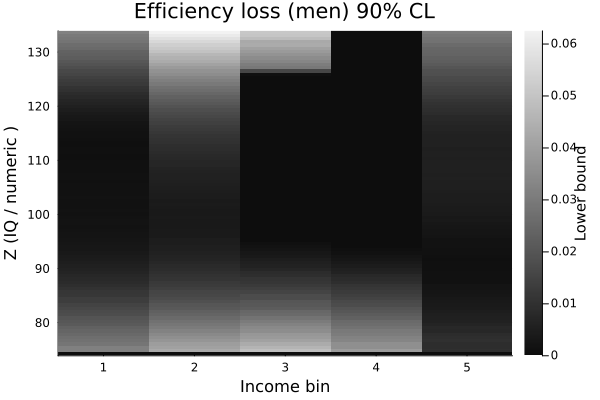

In [40]:
p=heatmap(
    1:B, zgrid, el_men;
    xlabel = "Income bin",
    ylabel = "Z (IQ / numeric )",
    title  = "Efficiency loss (men) 90% CL",
    color  = :grays,
    clims  = (0, maximum(el_men)),
    colorbar_title = "Lower bound"
)



In [41]:
savefig(p, joinpath(export_dir, "efficiency_loss_men.png"))


"/Users/jorditorresvallverdu/Documents/GitHub/TSE-2025-2026/set_identification/efficiency_loss_men.png"

**Appendix**



**Test for monothonicity of E(Y/Z=z)**
This boils down to testing whether the probability of Y=1 is increasing in Z. Usual tests include Hu, Shi (2019), Chetverikhov (2013). These tests, however, are done under much more complicated cases as in mine: Hu et al, for example, account for a setting with Y being continuous and Z also being continuous; in my case, I just need to test over Z=1,2,3...

Given that the idea is to use set identification techniques, I will provide some evidence that this holds or not for a given subset of the data. Then I will focus mostly on the el(z) measure.

In [42]:
size_subsample=10
size_p=3

m= zeros(Float64, size_subsample, size_p, size_p)

10×3×3 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [43]:
##Estimate probabilities 

function cell_probs(df, instrument::Symbol)
    zvals = sort(unique(df[!, instrument]))
    k = length(zvals)
    p_k = zeros(Float64, k)
    n_k = zeros(Int, k)

    for (i, z) in enumerate(zvals)
        num = sum((df.postsec_stem2 .== 1) .&
                  (df[!, instrument] .== z))

        n_k[i] = sum(df[!, instrument] .== z)
        p_k[i] = num / n_k[i]
    end

    return p_k, n_k
end



probs= [cell_probs(i, :z_numeric_iq) for i in subsamples]

10-element Vector{Tuple{Vector{Float64}, Vector{Int64}}}:
 ([0.26865671641791045, 0.3269230769230769, 0.2708333333333333, 0.41304347826086957, 0.3076923076923077, 0.4, 0.5714285714285714], [67, 52, 48, 46, 39, 25, 28])
 ([0.5714285714285714, 0.4583333333333333, 0.46875, 0.5, 0.6097560975609756, 0.5952380952380952, 0.6451612903225806], [28, 24, 32, 38, 41, 42, 62])
 ([0.16326530612244897, 0.225, 0.2571428571428571, 0.37142857142857144, 0.17857142857142858, 0.43478260869565216, 0.5], [49, 40, 35, 35, 28, 23, 20])
 ([0.6666666666666666, 0.631578947368421, 0.5555555555555556, 0.6, 0.6666666666666666, 0.625, 0.45], [15, 19, 18, 10, 15, 24, 20])
 ([0.2857142857142857, 0.25, 0.3111111111111111, 0.46808510638297873, 0.3055555555555556, 0.3157894736842105, 0.38095238095238093], [49, 48, 45, 47, 36, 38, 21])
 ([0.3333333333333333, 0.5263157894736842, 0.6551724137931034, 0.6, 0.6071428571428571, 0.6875, 0.65625], [27, 19, 29, 15, 28, 32, 32])
 ([0.1875, 0.3235294117647059, 0.25, 0.225806451612903

In [44]:
function compute_var(p_k, n_k)
    k = length(p_k)
    var = zeros(k)
    for j in 1:k
        var[j] = p_k[j] * (1 - p_k[j]) / n_k[j]
    end
    return var
end


compute_var (generic function with 1 method)

In [45]:
#Generate moment inequalities 
function monotonicity_AS(df, instrument::Symbol)

    p_k, n_k = cell_probs(df, instrument)
    var = compute_var(p_k, n_k)

    K = length(p_k)
    if K < 2
        error("Need at least 2 Z categories for monotonicity test.")
    end

    J = K - 1  # number of inequalities
    g = zeros(J)
    sig = zeros(J)

    for j in 1:J
        g[j] = p_k[j+1] - p_k[j]
        sig[j] = sqrt(var[j+1] + var[j])
    end

    n = nrow(df)
    tvals = zeros(J)
    for j in 1:J
        if sig[j] > 0
            tvals[j] = sqrt(n) * (-min(g[j], 0)) / sig[j]
        else
            tvals[j] = 0.0
        end
    end

    T = maximum(tvals)

    return g, sig, T
end


monotonicity_AS (generic function with 1 method)

In [46]:
T_vals = Float64[]
g_list = []
sig_list = []

for df_sub in subsamples
    g, sig, T = monotonicity_AS(df_sub, :z_numeric_iq)
    push!(T_vals, T)
    push!(g_list, g)
    push!(sig_list, sig)
end

T_vals ##same rejections as before

10-element Vector{Float64}:
 17.75991639216843
 13.37485865109482
 26.801390148796656
 12.937066058166597
 25.89070209784949
  4.825661239408463
 10.804590844148679
  2.6392300227004672
  7.688892903951603
 24.315006171778244

In [47]:
using Distributions
using Random

function boot_t_1(subsamples, instrument::Symbol, b_iter::Int64)

    nsubs = length(subsamples)
    T_dist = zeros(nsubs, b_iter)

    for b in 1:b_iter
        for i in 1:nsubs

            dt = subsamples[i]
            n_i = nrow(dt)

            hat_p = mean(dt.postsec_stem2)

            Y_b = rand.(Bernoulli(hat_p), n_i)

            dt_boot = deepcopy(dt)
            dt_boot.postsec_stem2 = Y_b

            _, _, T_dist[i, b] = monotonicity_AS(dt_boot, instrument)

        end
    end

    return T_dist
end


boot_t_1 (generic function with 1 method)

In [48]:
Random.seed!(12345)

T_dist = boot_t_1(subsamples, :z_numeric_iq, 1000)

# critical values
cv_95 = [quantile(T_dist[i,:], 0.95) for i in 1:length(subsamples)]
cv_90 = [quantile(T_dist[i,:], 0.90) for i in 1:length(subsamples)]
cv_85 = [quantile(T_dist[i,:], 0.85) for i in 1:length(subsamples)]


cv_85

10-element Vector{Float64}:
 34.63496960148269
 32.743631162685205
 31.361168476565915
 22.75106651943767
 35.147491092684206
 27.856953075226386
 31.115998256749503
 27.60078000526138
 32.272652170541065
 26.395254141161246

In [49]:
using DataFrames

function monot_table(subsamples, T_vals, cv_95, cv_90, cv_85)

    n = length(subsamples)

    df_out = DataFrame(
        subsample = Int[],
        income = String[],
        gender = String[],
        T_stat = Float64[],
        cv_95 = Float64[],
        cv_90 = Float64[],
        cv_85 = Float64[],
        reject_95 = Int[],
        reject_90 = Int[],
        reject_85 = Int[]
    )

    for i in 1:n

        income_i = string(unique(subsamples[i].c_sskills_income)[1])
        gender_i = string(unique(subsamples[i].c_iq_male)[1])

        T_i = T_vals[i]

        r95 = T_i >= cv_95[i] ? 1 : 0
        r90 = T_i >= cv_90[i] ? 1 : 0
        r85 = T_i >= cv_85[i] ? 1 : 0

        push!(df_out, (
            i,
            income_i,
            gender_i,
            T_i,
            cv_95[i],
            cv_90[i],
            cv_85[i],
            r95,
            r90,
            r85
        ))
    end

    return df_out
end

df = monot_table(subsamples, T_vals, cv_95, cv_90, cv_85)

Row,subsample,income,gender,T_stat,cv_95,cv_90,cv_85,reject_95,reject_90,reject_85
,Int64,String,String,Float64,Float64,Float64,Float64,Int64,Int64,Int64
1,1,1.0,0,17.7599,41.9466,37.3502,34.635,0,0,0
2,2,1.0,1,13.3749,40.1793,35.6684,32.7436,0,0,0
3,3,2.0,0,26.8014,38.5178,33.8102,31.3612,0,0,0
4,4,2.0,1,12.9371,29.796,25.3835,22.7511,0,0,0
5,5,3.0,0,25.8907,42.1774,38.5596,35.1475,0,0,0
6,6,3.0,1,4.82566,34.6674,30.5691,27.857,0,0,0
7,7,4.0,0,10.8046,39.1669,34.6403,31.116,0,0,0
8,8,4.0,1,2.63923,34.7965,30.8509,27.6008,0,0,0
9,9,5.0,0,7.68889,39.3692,35.3513,32.2727,0,0,0


**Unsuccesful trial:** IT BREAKS!

In [50]:
#Estimate test-->BREAKS!!

function pav3(pk, nk)
    p1, p2, p3 = pk
    n1, n2, n3 = nk

  #monothonicity holds
  if p1 ≤ p2 ≤ p3
    return pk
  end


  #case 1
  if p1>=p2
    
    θ_12= (p1*n1 + p2*n2)/(n1+n2)

    if p3>=θ_12
      return[θ_12, θ_12, p3]
    else 
    θ_123= (p1*n1 + p2*n2 + p3*n3)/(n1+n2+n3)

    return[θ_123,θ_123,θ_123]
    end 
  end 
  
  #case 2
  if p2>=p3

    θ_23= (p2*n2 + p3*n3)/(n2+n3)

    if p1<θ_23
      return[p1, θ_23, θ_23]
    else 
      θ_123= (p1*n1 + p2*n2 + p3*n3)/(n1+n2+n3)
     return[θ_123,θ_123,θ_123]
    end 

  end 


end

pav3 (generic function with 1 method)

In [51]:
p_hat= zeros(length(subsamples), length(zvals))

for i in 1:length(subsamples)

    pk, nk = probs[i]

    p_hat[i,:]= pav3(pk,nk)
end 

p_hat

DimensionMismatch: DimensionMismatch: tried to assign 7-element array to 1×3 destination

In [52]:
n=zeros(length(subsamples))
T=zeros(length(subsamples))
[n[i]= nrow(subsamples[i]) for i in 1:length(subsamples)]

for i in 1:length(subsamples)

    pk, nk= probs[i]
    p_hat[i,:]= pav3(pk,nk)

    T[i]= sqrt(n[i])* maximum(pk .- p_hat[i,:])
end

T

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size: a has axes Base.OneTo(7) and b has axes Base.OneTo(3)

In [53]:
for i in 1:length(subsamples)
    println((i, unique(subsamples[i].c_sskills_income), unique(subsamples[i].c_iq_male), T[i]))
end


(1, Union{Missing, Float32}[1.0], Union{Missing, Int8}[0], 0.0)
(2, Union{Missing, Float32}[1.0], Union{Missing, Int8}[1], 0.0)
(3, Union{Missing, Float32}[2.0], Union{Missing, Int8}[0], 0.0)
(4, Union{Missing, Float32}[2.0], Union{Missing, Int8}[1], 0.0)
(5, Union{Missing, Float32}[3.0], Union{Missing, Int8}[0], 0.0)
(6, Union{Missing, Float32}[3.0], Union{Missing, Int8}[1], 0.0)
(7, Union{Missing, Float32}[4.0], Union{Missing, Int8}[0], 0.0)
(8, Union{Missing, Float32}[4.0], Union{Missing, Int8}[1], 0.0)
(9, Union{Missing, Float32}[5.0], Union{Missing, Int8}[0], 0.0)
(10, Union{Missing, Float32}[5.0], Union{Missing, Int8}[1], 0.0)


In [54]:
using Distributions
using Random
Random.seed!(12345)   #seed



T_dist= zeros(length(subsamples), b_iter)

##set seed!!!
function boot_t(instrument::Symbol, b_iter::Int64)

 T_dist= zeros(length(subsamples), b_iter)

  for b in 1:b_iter
    for i in 1:length(subsamples)

          dt = subsamples[i]   ##then we loop over i 
          p_iso = p_hat[i,:]   
          Z = dt[!, instrument] 
          p_obs = p_iso[Z]   
          Y_b = rand.(Bernoulli.(p_obs))

          dt_boot = deepcopy(dt)       
          dt_boot.postsec_stem2 = Y_b   #simul replace

          pk_b, nk_b= cell_probs(dt_boot)
          p_iso_b= pav3(pk_b,nk_b)
          T_dist[i,b]= sqrt(n[i])* maximum(pk_b .- p_iso_b)
    end 
  end
  
  return T_dist

end 


T_dist= boot_t(:z_numeric_iq, 1000)




UndefVarError: UndefVarError: `b_iter` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [55]:
using Statistics

c_value_95= zeros(length(subsamples))
c_value_90= zeros(length(subsamples))

[c_value_95[i]= quantile(T_dist[i, :], 0.95) for i in 1:length(subsamples)]
[c_value_90[i]= quantile(T_dist[i, :], 0.90) for i in 1:length(subsamples)]



10-element Vector{Float64}:
 37.350213910057185
 35.668361064885275
 33.8102060281684
 25.38350663499
 38.55956633912844
 30.569140888106478
 34.64029592313845
 30.85085939543906
 35.35125534496015
 29.04426318905199

In [56]:
t_result95= zeros(length(subsamples))
t_result90= zeros(length(subsamples))

for i in 1:length(subsamples)
    if (T[i]>=c_value_95[i])
        t_result95[i]=1
    else 
        t_result95[i]=0
    end

    if (T[i]>=c_value_90[i])
        t_result90[i]=1
    else 
        t_result90[i]=0
    end


end 

tests= [t_result95 t_result90]

10×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0